#An Introduction to Bias-Variance

##Introduction

<p>This notebook gives a foundational overview of the Bias-Variance tradeoff,  one of the most important topics related to predictive modeling for Data Science. The Bias-Variance Tradeoff in short is a framework for understanding where error comes from in a supervised learning model. There is a famous quote attributed to statistician George Box that goes:<br><br>

<i><center>"All models are wrong, though some are useful.</center></i><br>

The word "model" alone implies some simplification of the world, and such simplifications generally accept a level of misrepresentation for the sake of parsimony (ie., simplicity). The challenge we face as Data Scientists is that the world we are usually trying to model produces data that is inherently noisy. Modeling such noisy systems requires a delicate balancing act between model parsimony and generalizability. When our measurement systems are rife with uncertainty, the desire to build simpler models isn't just a stylistic choice - it is an essential practice if we desire to successfully generalize on unknown data.<br><br>

The Bias-Variance tradeoff is a theoretical concept that fortunately can be very intuitive and easy to illustrate. This notebook aims to offer the reader both views. On the theory side, we'll define and explain some core constructs and show how the common least squares error can be decomoposed into both bias and variance components. To make the concepts more intuitive, we'll present multiple illustrations with simulated data. The rest of this notebook is organized as follows:<br>


<ul>
    <li>Explore and define Bias and Variance with a focus on illustration.</li>
    <li>Derive the Bias-Variance decomposition for least squares error.</li>
    <li>Discuss practical considerations that result from the Bias-Variance decomposition.</li>
</ul>
</p>

##Intuitive Explanation of Bias and Variance.
<p>Both "bias" and "variance" are common terms in statistics, and their general meaning isn't that far from how they are used in statistical learning theory. If you recall in statistics, the bias of an estimator is defined as the difference between the expected value of an estimator and the true value of the quantity being estimated. The "bias" and "variance" of a predictive model follow the same idea since you can think of a model as a function that estimates the expected value of an outcome $Y$ conditional on some $X=x$,  (i.e., $f(x)=E[Y|X=x]$).

<br><br>

So to get closer to an intuitive explanation, let's start by looking at some simulated data. The following plots show a polymonial scatter created with the following data generating process:<br><br>

<center>$Y=\beta^T \: K^d(X) + \epsilon$</center><br>

Where $X$ is a single numeric variable, $K^d(X)$ is a $d$-degree polynomial kernel on $X$ (i.e., $K^3(X)$ admits a vector $<X^3, X^2, X>$), $\beta$ is a $d$-length coefficient vector and $\epsilon$ is a normal random variable with $0$-mean and variance $\sigma^2$.
</p>

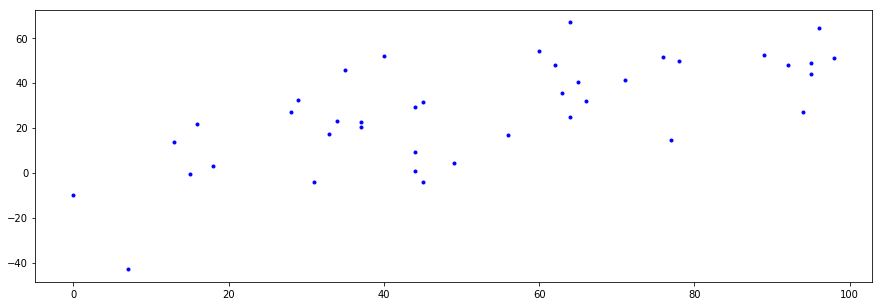

In [1]:
import sys
sys.path.append("./utils/")
import numpy as np
import bias_variance_2018 as bv
import importlib
importlib.reload(bv)

from matplotlib import pyplot as plt
#note matplotlib inline has to be called
%matplotlib inline

b = [-10, 2, -0.04, 0.000275]
d = bv.simPolynomial(sigma = 20, betas = b, n = 40)
plt.figure(figsize=(15, 5))
plt.plot(d['x'], d['y'], 'b.')


<p>The points above follow some sort of trend, but given the level of noise, it is hard to trace exactly what that trend is. Imagine you didn't know the data generating function and that someone gave you a piece of string and asked you to lay the string out so that it best captures the trend you see in the data. The string, once laid out, is your mental model of how this data was generated. Although a piece of string is infinitely flexible, imagine that you are required in advance to specify exactly how many times your piece of string is allowed to bend. If your only task was to draw a trend line that was as close to as many points above as possible, you'd likely choose the infinitely flexible option. Your game master here reveals though that there is another set of points hidden from you, and the real task is to have your string be as close to the hidden points as possible (which we'll assume will at least come from the same data generating process). With this revelation, you'd have to ask yourself whether you prefer a string with fewer flex points, that sits near a safe average of any cluster of points, or the infinitely flexible string that can possibly go through all points. This is the choice that every modeler has to make, and understanding both bias and variance will help guide us towards making better modeling choices.

</p>

####Deeper Look at Bias
<p>
Your choice will likely depend on how confident you are that the points you see really represent the world of such points. Your confidence in that department is likely proportional to the number of points you can see here. Even if you had an infinite number of points, the string with fewer flex points might never be able to trace the true trend in the data. We'll illustrate this with the following chart, using a straight line (string with zero flexibility) as our model.
</p>

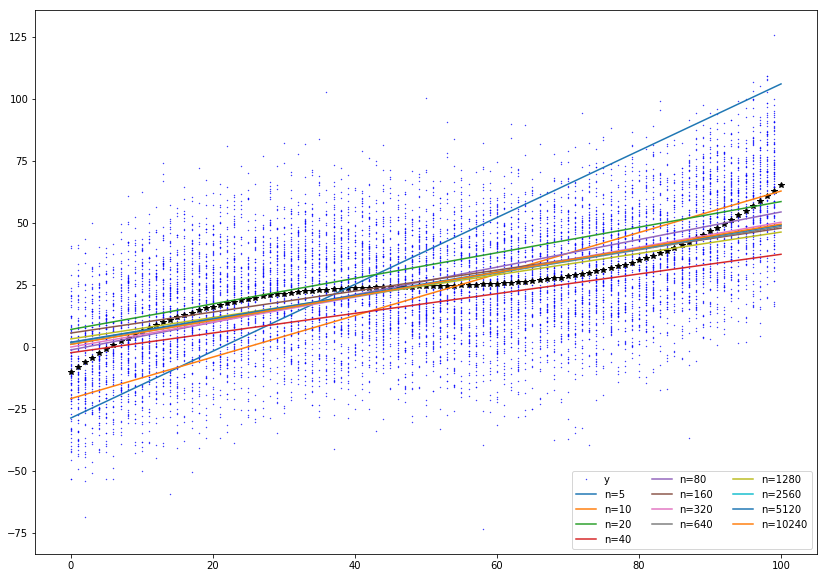

In [2]:
import imp
imp.reload(bv)
bv.plotLinearBiasStage(20, b, 5*np.array([2**i for i in range(12)]), (14, 10))

<p>The blue dots represent the data we are trying to model. Each line is a linear model fit to a different data set from the data generating model (same as above), but with increasingly more points. You can see that most of the lines cluster together, and that the line fit with the most points is right in the middle there. The starred, black-curve running through the middle is the true mean of the distribution (i.e., $E[Y|X]$ if you were to have infinitely many data points to model). We can see that even the linear model fit on the most data is far away from this true mean at various points. If we extended the simulation and modeled with infinitely large data sets, nothing would change this fact: a linear model will never truly fit the curvature of the data. This is an example of model bias. Because this is a regression problem, we can even quantify this bias: <br><br>

A linear model will take the form:<br>
<center>$E^{d=1}[Y|X=x]=\hat{\beta} *\:x$</center><br>

But we know that our data follows the form $Y=\beta^T \: K^d(X) + \epsilon$ and a properly specified model would give the following estimate:<br><br>

<center>$E[Y|X=x]=\beta^T \: K^d(X)$</center><br>

The bias of the linear model is the difference between its estimate of $E^{d=1}[Y|X]$ and the true $E[Y|X]$, which is:<br><br>

<center> Bias(d=1) = $|E^{d=1}[Y|X=x] - E[Y|X=x]| = |\hat{\beta} *\:x - \beta^T \: K^d(X)|$</center><br>

Bias is not a quantity that you can reduce by adding more data (directly at least), because it is a property of the type of model you have chosen a priori to fitting the data. The expecations above are take over the true probability distribution $P(X,Y)$ and have nothing to do with the actual training data sample (and specifically, the quantity of it). The consequence of this fact is that adding more data without changing the form of the model won't make any bias disappear (if it is to exist at all). Thus, can't reduce any error caused by bias if we can't change the model structure we are using. <br><br>

<i>So why not just make models as flexible as possible?</i><br><br>

This is a perfect segueway for discussing variance in model estimation.
</p>

####Deeper Look at Variance

<p>

Core machine learning theory focuses a lot of attention on how flexible a particular type of model can be. The best algorithms (in terms of accuracy) are usually the ones that can fit any arbitrary function that may represent the classification or regression task. Of course, with great power comes great responsibility. When we seek to reduce bias by using more sophisticated modeling algorithms, we have to be mindful that a lot of algorithms are really good at fitting the noise in our data. With smaller data sets, the models have a harder time distinguising inherent noise from signal. Variance in this context is thus intimately linked to the size of the data set.<br><br>

An important concept for understanding model variance is to define the variance of 'what' over 'what.' Remember again that a model generally tries to estimate $E[Y|X]$, and we use a given training set $j$ to learn this estimate. Every training set though is just some sample over a larger, hypothetical distribution $D$ (that in practice we generally never know). Now imagine a set of parallel worlds, each having some different (but similar) dataset $j$ sampled from $D$.  Now further imagine that we estimate a different $E^j[Y|X]$ over each $D^j$ using some algorithm with a fixed structure. Because of the random permutations and differences of the different training sets, we should expect each $E^j[Y|X]$ to be slightly different than the next. Exactly how different is the appropriate question here. More flexible models will likely produce more varied estimates, and this variation will increase as sample sizes decrease. So in short, the variance we refer to here is $Var(E^j[Y|X])$, over possible different permutations of the data set. <br><br>

The following illustrates this idea using the simulation example from above. In this case we compare a biased (linear) model to a zero-bias model with different sized training sets. We simulate the parallel world concept and plot the results of the model trained on each 'world.'
</p>

No handles with labels found to put in legend.


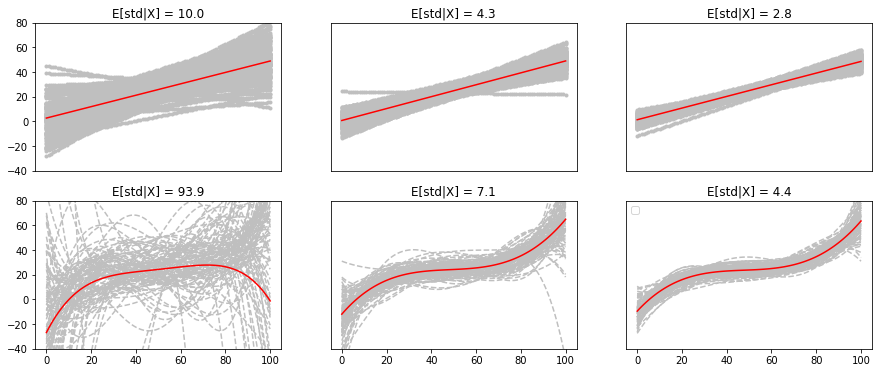

In [3]:
import bias_variance_2018 as bv
import imp
imp.reload(bv)
bv.plotVariance(20, b, [10, 50, 100], (15, 6))

<p>This chart paints several trends around the idea of model variance. First though, let's arm ourselves by actually defining model variance. For a particular value of $X=x$:<br><br>

<center> Model Variance = $E_D[(\hat{Y}_x - E_D[\hat{Y}_x])^2]$</center><br><br>

For notational convenience, we define $\hat{Y}_x = E_j[Y|X=x]$, where $j$ indicates a particular data set (i.e., this is the estimated model fit for a particular value of $X=x$ on a particular instance of the training data $j$). The notation $E_D[.]$ means we are taking an expectation over all possible datasets $j$ of size $N$ that are sampled from $D$. In each chart above, the red line is the avg. of $\hat{Y}_x$, which is an unbiased and consistent estimator of $E_D[\hat{Y}_x]$. Each grey line represents the model estimated from each training set $j$ in our simulation. The quantity $E[std|X]$ represented in the title is the avg. standard deviation (square root of variance) across all values of $X$ in the data. <br><br>

With the core concepts and charts defined, we can focus on the interesting trends shown above. Visually we can see that the variance increases as we switch from the biased linear model (top row) to the unbiased polynomial model (bottom row). We can also see that the variance decreases left to right for both model classes, which is caused by adding more data to each model. So in short, model variance tends to increase under two scenarios: 1) the model you are fitting is more flexible or complex, 2). sample sizes decrease. Intuitively, this should make sense. More flexible models can essentially go through more points. The problem though, is that a lot of the points are just noise, and so in any one realization of the data, the model has less evidence to distinguish whether the point is signal or noise. A biased and inflexible model doesn't care as much about noise - it doesn't have what it takes to fit the noise. <br><br>

One subtle but important item to point out here is that the dispersion of the models (grey lines) around their average is not equal for all values of $X$. In particular, we can see more dispersion around extreme points. If you recall, the data generating process had an error term with equal variance for each value of $X$ (homoscedasticity is what we call that - the assumption that the variance around the regression line is the same for all values of the predictor variable $X$). So how do we end up with extra variance at the extreme values? This is a subtle but important point that happens a lot in modeling. In most cases, data is not uniformly distributed around $X$, so extreme ranges tend to have less support. Since we defined model variance above conditioned on $X=x$, what matters more is not the total sample size, but the number of instances where $X=x$. It turns out that model variance is often higher where $P(X=x)$ is lower. This technically doesn't explain the results above though, because the data was generated uniformly random on $X$. In a related, but different way, the extreme values have more variance because each extreme value has fewer points near it. Parametric models (which is what we have here) "borrow" information from neighboring points to get a good fit. When a point has fewer neighbors (which is the case at the boundaries), there are fewer neighbors to exploit. <br><br>

So how much data is required to reduce or at least stabilize the variance? The exact sample size is heavily problem, model and data dependent, and there are some rules of thumb. We can at least extend the above simulation to show the basic trend. 


</p>

In [ ]:
np.random.normal(0, 20, 100)


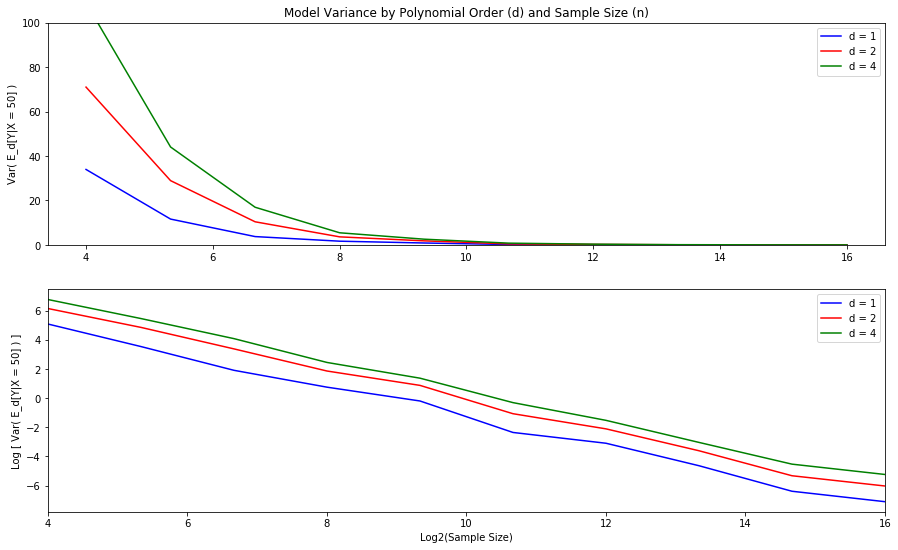

In [5]:
import bias_variance_2018 as bv
import imp
imp.reload(bv)
res=bv.getVarianceTrend(20, b)
bv.plotVarianceTrend(res, (15, 9))

<p>This plot should confirm several of our expectations. First, when the complexity of our models increase (measured by the degree of the polynomial), model variance increases. Also, variance decreases as we increase the sample size. Beyond that, note the shape of the curves in the top plot above (for any model degree). We can see that doubling the data (each tick on the x-axis represents a doubling) does not halve the variance. For instance, with $d = 4$ (our one unbiased model family), going from $2^{10}$ to $2^{11}$ records drops the variance around 50%. The bottom chart shows both the sample size and model on the log2 scale. We can see that relationship on the log-log scale is nearly perfectly linear. Every unit increase in log2 scale decreases the log2 of the variance by a constant amount, such that: $log_2(\hat{\sigma_m}^2) =  -log_2(N) + c$. With a little algebra we get to $\hat{\sigma_m}^2 \propto N^{-1}$. Here we have shown empirically what is well known analytically - that model variance reduces at the rate of $O(N^{-1})$. For reasons that we'll discuss later, investing in more and more data to reduce the variance doesn't always pay off (in terms of reducing error to balance out the additional data cost).
</p>

##Model Error, Bias and Variance

<p>So at this point we should have a solid foundation as to what exactly we mean by a model's bias and variance. And most importantly, we should now be able to understand the drivers of model bias and variance. Understanding such drivers gives the modeler an element of control over the two phenomena. But why do we need to control such things? After all, our modeling goal is generally not to hit some target level of bias or variance. Rather, we want to reduce the prediction error of our model. It turns out, bias and variance are intimately connected to model error, such that the total model error is often explicitly determined by the amount of bias or variance. Thus, controlling bias and variance in essence helps us control the error.
</p>

###Bias-Variance Decomposition for Least-Squares Error

<p>
The most famous and convenient representation of this relationship is done using least-squares error. For problems in which MSE (least squares) is our error function, we can express the MSE explicitly in terms of model bias, model variance and the underlying noise in our target data (which is often called the 'irreducible error', for reasons discussed later on). In this section we'll derive this famous decomposition.<br><br>


##Improving Models Using the Bias-Variance Framework

<p>Understanding the bias-variance decomposition isn't just a theoretical exercise. Quite the opposite, it is the most fundamental principal that governs model generalizability and its lessons are directly applicable to empirical problems. Here are some key takeaways that we can highlight based on the above analysis that can be directly applied to our work. <br><br>

<b>More data is always better:</b><br><br>
This is probably an obvious statement based on everything we hear about "Big Data," but now we have a framework to understand why. Having more data examples reduces model estimation variance at the rate of $O(N^{-1})$, which all else being fixed (remember, more data doesn't change the bias or irreducible error given a fixed model family), reduces the total error. An important caveat is that the value of this variance reduction might not be proportional to the costs associated with increased data. This is a very problem specific trade-off that should at least always be considered (remember, data costs can be in actual economic currency or CPUs). 

<b>Model complexity is your friend, but it can stab you in the back if you are not careful:</b><br><br>
The bias part of the error decomposition is purely a function of your model specification and is independent of the data (specifically, the number of examples, not features, in your data). One can often get better results by using more complex (flexible) modeling algorithms. Example ways to add model complexity are: adding new features to the dataset, using less regularization in linear models, adding non-linear kernel functions to SVMs, using Neural Networks or Decision Tree based methods over linear methods. <br>

The major caveat is worthy of its own paragraph here. Given a finite data set, adding more complexity will almost always increase the estimation variance of your model. As discussed above, more flexible models will confuse more noise (the $\epsilon$ part of $Y=f^*+\epsilon$) for signal. Thus, we have to be very careful here. Adding more data given a fixed model family might only waste time, money or CPUs, but it won't make your model worse. Adding more complexity can really hurt you if not done carefully. So this begs the questions:<br>

<i>How much model complexity should I use?</i>

<ul>
<li>This is ultimately an empirical question, as the truth is never known outside of carefully crafted simulations. This is why we ALWAYS use train/test splits or cross-validation to guide our model selection. While we have a good analytic model for knowing how increased sample size will decrease variance, we don't have the same for predicting how increased complexity will increase it. Thus, we have to carefully test our models on out-of-sample data to find the empirically optimal trade-off. <br>
</li>
</ul>


<i>How do I know if my model is suffering from too much bias or too much variance.</i> <br>
<ul>
<li>The best performing model on out-of-sample data again will be the one that is 'just-right' in terms of its bias and variance. Generally, the sweet-spot will be the level of complexity in which the testing error is the lowest. Given a particular model fit, we can diagnose whether it suffers from high/low bias/variance buy comparing both the training and the testing error. If the training error and testing errors are both high, then bias is the likely culprit. If training error is low but testing error is high, then variance is likely the culprit. The following chart (taken from the book Elements of Statistical Learning 2) shows a hypothetical example. In a realistic case, the x-axis will be defined by whatever parameters define complexity for your choice of algorithms (i.e., the regularization weight, depth of trees, number of trees in a forest, etc.).


</li>
</ul>




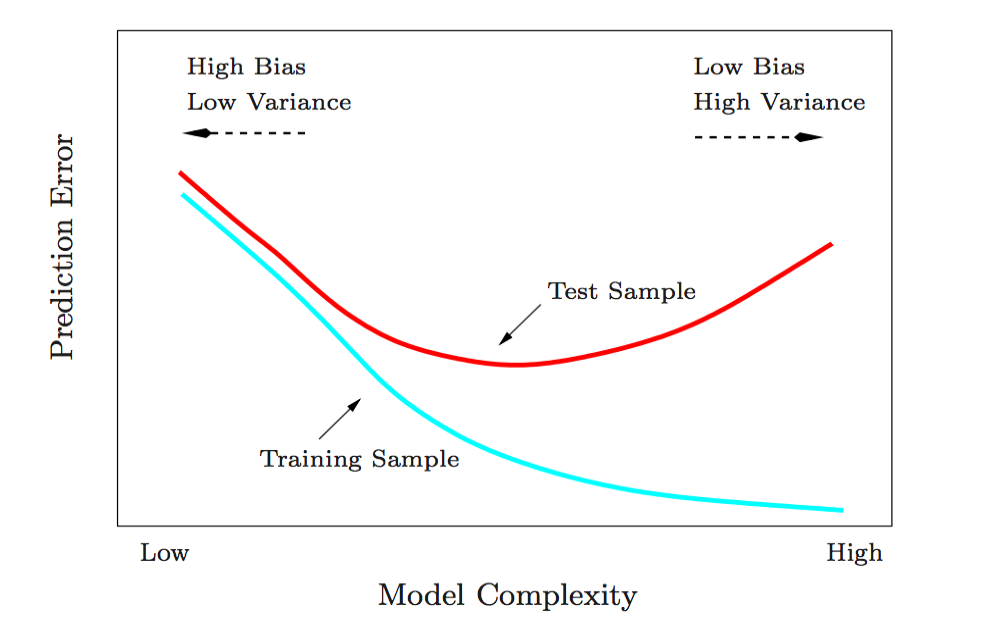

In [7]:
from IPython.display import Image
Image(filename='references/bv_complexity_es2.png') 

<p>
<b>In most observed phenomena, you can never get perfect predictions. Also, you shouldn't really compare models across different problems</b><br><br>

These are two different statements, but they're both related to that $\sigma^2$ term, which again we call the irreducible error. The first statement should be obvious if we assume $\sigma>0$. Almost all systems we attempt to model, especially systems that capture human dynamics, are burdened with noise. With an infinite sample size we can potentially test every possible function and arrive at both zero variance and zero bias. Even then, the quantum mechanical nature of the universe, and the fact that there is always likely some unmeasured variable (whose effect can be folded into $\epsilon$), means that $Y$ will always have some unexplainable variance. No model and modeler will ever get beyond that point (for those interested, this error is often called the 'Bayes Error').<br><br>

The second statement above is related to the fact that every $Y^p$ will have an associated $\epsilon^p$. A model predicting $E[Y^1|X=x]$ may have both lower bias and variance than a model predicting $E[Y^2|X=x]$, but if $Var[\epsilon^1]>Var[\epsilon^2]$, the model on $Y^1$ can still have a worse error than the one for $Y^2$. Generally this isn't a problem, so long as the appropriate comparisons are made. Specifically, the qualitative assessment of a model should be relative to a baseine derived from the same problem (i.e., predicting the same $Y^p$). And in some circumstances, a model that does 5% better than random on some problem may be worth a lot more money than a model that is nearly perfect (think about predicting stocks vs. predicting sunset). <br><br>

Corrollary to the above paragraph is the following rule: don't judge a model just because its error is too close to random. Again, every model should be judged using appropriate baselines that are specific to the problem at hand. Accuracy might be far from 100%, but the model can still be good (and this relates back to how much irreducible error is in the underlying system).
</p>

##Wrap Up

<p>At this point you should (hopefully) understand the following at both an intuitive level and foundational theoretical level:

<ul>
    <li>Model Bias</li>
    <li>Model Variance</li>
    <li>The relationship between bias, variance and prediction error</li>
    <li>How to simulate and represent graphically model bias and variance</li>
    <li>How to use the bias-variance tradeoff to guide your modeling decisions</li>
 </ul><br>

<b>references</b><br><br>

The presentation here was intentionally light on theory and mainly focused on the bias-variance decomposition of MSE. For further exploration of the topic, feel free to consult the following:<br><br>
 
<ul>
    <li><a href="https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff">Wikipedia</a></li>
    <li><a href="http://statweb.stanford.edu/~tibs/ElemStatLearn/">The Elements of Statistical Learning 2 (section 2.9, chapter 7)</a></li>
    <li><a href="http://papers.nips.cc/paper/3323-the-tradeoffs-of-large-scale-learning.pdf">Leon Bottou's work on the Tradeoffs of Large Scale learning (section )</a></li>
    <li><a href="http://homes.cs.washington.edu/~pedrod/papers/mlc00a.pdf">Pedro Domingo's General Framework for the Bias Variance Tradeoff</a></li>
</ul>
 
 